本文主要参考《Python数据分析与挖掘实战》中的相关内容。但是本人不赞同作者在书中对相关指标的设定，故在本文中做了一定的调整。

本数据集将2012.4.1至2014.3.31作为观察窗口，抽取了该时间段内乘机客户的所有详细数据进行分析。

1.数据预览。
（原书提供了相关字段的解释）

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv(r"D:\学习\机器学习\数据分析\《Python数据分析与挖掘实战》源数据和代码\Python数据分析与挖掘实战\chapter7\demo\data\air_data.csv")

In [4]:
df.shape

(62988, 44)

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MEMBER_NO,62988.0,31494.500000,18183.213715,1.00,15747.750000,31494.500000,47241.250000,62988.000000
FFP_TIER,62988.0,4.102162,0.373856,4.00,4.000000,4.000000,4.000000,6.000000
AGE,62568.0,42.476346,9.885915,6.00,35.000000,41.000000,48.000000,110.000000
FLIGHT_COUNT,62988.0,11.839414,14.049471,2.00,3.000000,7.000000,15.000000,213.000000
BP_SUM,62988.0,10925.081254,16339.486151,0.00,2518.000000,5700.000000,12831.000000,505308.000000
EP_SUM_YR_1,62988.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000
EP_SUM_YR_2,62988.0,265.689623,1645.702854,0.00,0.000000,0.000000,0.000000,74460.000000
SUM_YR_1,62437.0,5355.376064,8109.450147,0.00,1003.000000,2800.000000,6574.000000,239560.000000
SUM_YR_2,62850.0,5604.026014,8703.364247,0.00,780.000000,2773.000000,6845.750000,234188.000000
SEG_KM_SUM,62988.0,17123.878691,20960.844623,368.00,4747.000000,9994.000000,21271.250000,580717.000000


2.数据处理

数据中存在“总票价”为0，但“总飞行公里数”不为0的吊诡现象。删除这部分后剩余62044行数据，可见这部分数据量很小，所以直接删除。（“总飞行公里数”为0，且平均折扣为0的不在此列）

In [6]:
df = df[df["SUM_YR_1"].notnull() & df["SUM_YR_2"].notnull()]
index1 = df["SUM_YR_1"] != 0
index2 = df["SUM_YR_2"] != 0
index3 = (df["SEG_KM_SUM"] == 0) & (df["avg_discount"] == 0)
df = df[index1 | index2| index3]
print(df.shape)

(62044, 44)


In [7]:
df1 = df[[ "FFP_DATE", "LOAD_TIME", "FLIGHT_COUNT", "SUM_YR_1", "SUM_YR_2", "SEG_KM_SUM", "AVG_INTERVAL" , "MAX_INTERVAL", "avg_discount"]]
df1.head()

,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,SUM_YR_1,SUM_YR_2,SEG_KM_SUM,AVG_INTERVAL,MAX_INTERVAL,avg_discount
0,2006/11/02,2014/03/31,210,239560.0,234188.0,580717,3.483254,18,0.961639
1,2007/02/19,2014/03/31,140,171483.0,167434.0,293678,5.194245,17,1.252314
2,2007/02/01,2014/03/31,135,163618.0,164982.0,283712,5.298507,18,1.254676
3,2008/08/22,2014/03/31,23,116350.0,125500.0,281336,27.863636,73,1.090870
4,2009/04/10,2014/03/31,152,124560.0,130702.0,309928,4.788079,47,0.970658


最终选择以下字段为之后的建模做准备：

入会时间：表明旅客的忠诚度。

每公里票价：单看总票价或者单看总里程数都是片面的，重点在于一个客户在单位里程上为航空公司创造的价值。

季节性指数：该指数=最大飞行间隔-平均飞行间隔。如果一个客户的平均飞行间隔为1个月，但是最大飞行间隔为6个月，可见该客户的飞行时间都集中在某个几月，或者某个季节中。故设定此参数作为一个评价维度。

飞行次数：观察窗口内的总飞行次数

总里程：观察窗口内的总飞行里程。乘以每公里票价即为一个客户为航空公司创造的总价值。

平均折扣率：一个客户的价值越高，所能获得的航司折扣也会越高。

In [9]:
df1["LOAD_TIME"] = pd.to_datetime(df1["LOAD_TIME"])
df1["FFP_DATE"] = pd.to_datetime(df1["FFP_DATE"])
df1["入会时间"] = df1["LOAD_TIME"] - df1["FFP_DATE"]
df1["每公里票价"] = (df1["SUM_YR_1"] + df1["SUM_YR_2"]) / df1["SEG_KM_SUM"]
df1["季节性指数"] = df1["MAX_INTERVAL"] - df1["AVG_INTERVAL"]
df_temp = df1.rename(columns = {"FLIGHT_COUNT" : "飞行次数", "SEG_KM_SUM" : "总里程", "avg_discount" : "平均折扣率"},inplace = False)
df1 = df_temp[["入会时间", "飞行次数", "每公里票价", "总里程", "季节性指数", "平均折扣率"]]
df1['入会时间'] = df1['入会时间'].astype(np.int64)/(60*60*24*10**9)
#这里之所以是10的9次方，因为默认的是ns，纳秒

In [10]:
#df['总票价']=df["SUM_YR_1"] + df["SUM_YR_2"]

In [11]:
df1.head()

,入会时间,飞行次数,每公里票价,总里程,季节性指数,平均折扣率
0,2706.0,210,0.815798,580717,14.516746,0.961639
1,2597.0,140,1.154043,293678,11.805755,1.252314
2,2615.0,135,1.158217,283712,12.701493,1.254676
3,2047.0,23,0.859648,281336,45.136364,1.090870
4,1816.0,152,0.823617,309928,42.211921,0.970658


数据标准化（归一化），将有量纲数据转化为无量纲数据。

In [12]:
df1_z = (df1 - df1.mean(axis=0))/(df1.std(axis=0))
df1_z.head()

,入会时间,飞行次数,每公里票价,总里程,季节性指数,平均折扣率
0,1.435707,14.034016,0.605115,26.761154,-0.987974,1.295540
1,1.307152,9.073213,1.812903,13.126864,-1.019566,2.868176
2,1.328381,8.718869,1.827807,12.653481,-1.009128,2.880950
3,0.658476,0.781585,0.761692,12.540622,-0.631155,1.994714
4,0.386032,9.923636,0.633034,13.898736,-0.665235,1.344335


查看是否还有无空值。

In [13]:
df1_z.isnull().sum().sort_values()

入会时间     0
飞行次数     0
每公里票价    0
总里程      0
季节性指数    0
平均折扣率    0
dtype: int64

计算簇惯性，寻找“拐点”。

In [14]:
from sklearn.cluster import KMeans

def distEclud(vecA, vecB):
    #计算两个向量的欧式距离的平方，并返回
    return np.sum(np.power(vecA - vecB, 2))
 
def test_Kmeans_nclusters(data_train):
    """
    计算不同的k值时，SSE的大小变化
    """
    data_train = data_train.values
    nums=range(2,10)
    SSE = []
    for num in nums:
        sse = 0
        kmodel = KMeans(n_clusters=num, n_jobs=4)
        kmodel.fit(data_train)
        # 簇中心
        cluster_ceter_list = kmodel.cluster_centers_
        # 个样本属于的簇序号列表
        cluster_list = kmodel.labels_.tolist()
        for index in  range(len(df1_z)):
            cluster_num = cluster_list[index]
            sse += distEclud(data_train[index, :], cluster_ceter_list[cluster_num])
        print("簇数是",num , "时； SSE是", sse)
        SSE.append(sse)
    return nums, SSE
 
nums, SSE = test_Kmeans_nclusters(df1_z)


簇数是 2 时； SSE是 296587.45561529545
簇数是 3 时； SSE是 245317.4650187024
簇数是 4 时； SSE是 209299.5038199704
簇数是 5 时； SSE是 183886.01343917864
簇数是 6 时； SSE是 167465.0830192866
簇数是 7 时； SSE是 151869.2093479478
簇数是 8 时； SSE是 142922.55531951945
簇数是 9 时； SSE是 135598.5534458306


数据可视化，观察SSE与K取值，尝试找出合适的K值。

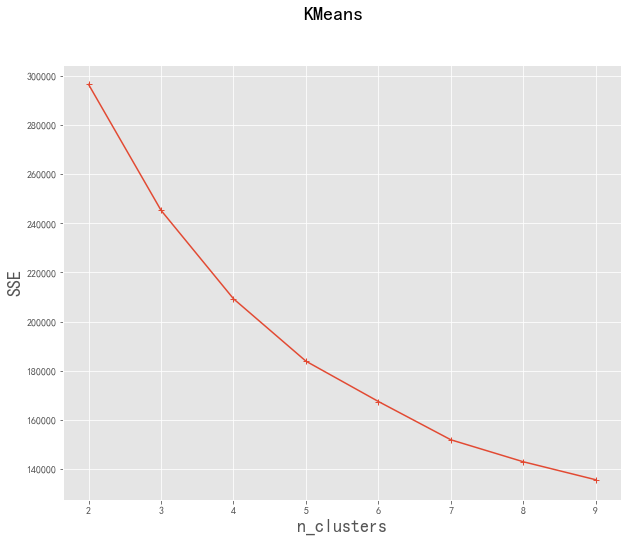

In [15]:
# 中文和负号的正常显示
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['font.size'] = 12.0
plt.rcParams['axes.unicode_minus'] = False
# 使用ggplot的绘图风格
plt.style.use('ggplot')
## 绘图观测SSE与簇个数的关系
fig=plt.figure(figsize=(10, 8))
ax=fig.add_subplot(1,1,1)
ax.plot(nums,SSE,marker="+")
ax.set_xlabel("n_clusters", fontsize=18)
ax.set_ylabel("SSE", fontsize=18)
fig.suptitle("KMeans", fontsize=20)
plt.show()


图中并没有出现明显的“拐点”，故尝试通过分析来确定K值。

下面三部分分别为K值取4、5、6之后的数据可视化。

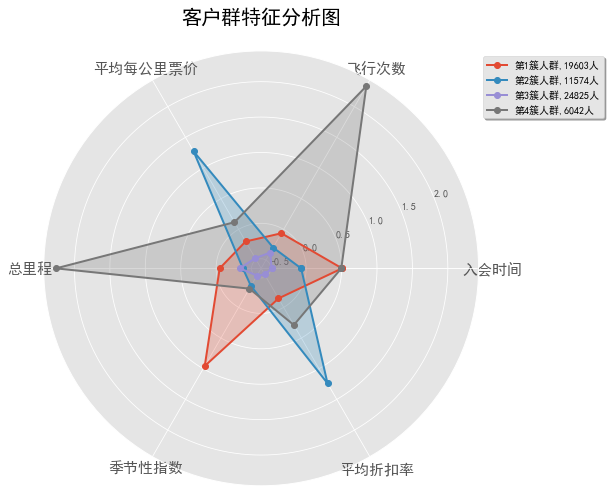

In [16]:
kmodel = KMeans(n_clusters=4, n_jobs=4)
kmodel.fit(df1_z)
# 简单打印结果
r1 = pd.Series(kmodel.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(kmodel.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max_bad = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(df1_z.columns) + [u'类别数目'] #重命名表头
 
# 绘图
fig=plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ["入会时间", "飞行次数", "平均每公里票价", "总里程", "季节性指数", "平均折扣率"]
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max_bad+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()


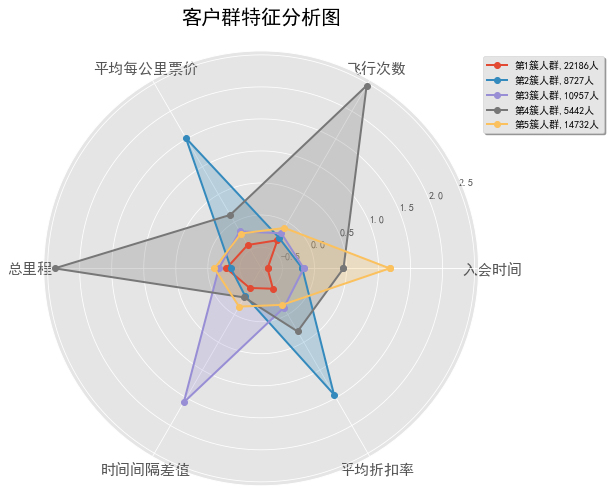

In [17]:
kmodel = KMeans(n_clusters=5, n_jobs=4)
kmodel.fit(df1_z)
# 简单打印结果
r1 = pd.Series(kmodel.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(kmodel.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max_bad = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(df1_z.columns) + [u'类别数目'] #重命名表头
 
# 绘图
fig=plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ["入会时间", "飞行次数", "平均每公里票价", "总里程", "时间间隔差值", "平均折扣率"]
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max_bad+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()


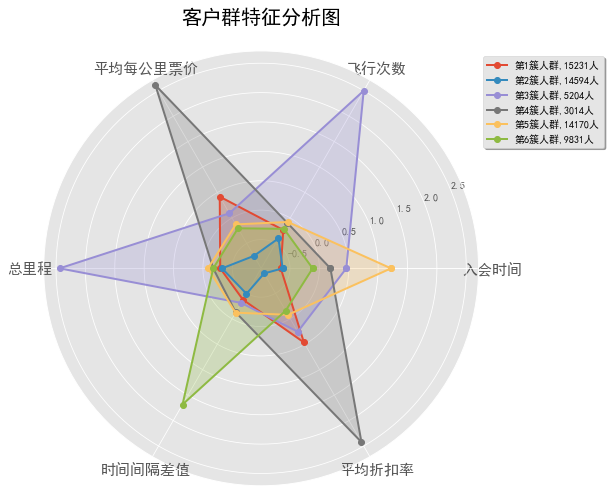

In [18]:
kmodel = KMeans(n_clusters=6, n_jobs=4)
kmodel.fit(df1_z)
# 简单打印结果
r1 = pd.Series(kmodel.labels_).value_counts() #统计各个类别的数目
r2 = pd.DataFrame(kmodel.cluster_centers_) #找出聚类中心
# 所有簇中心坐标值中最大值和最小值
max = r2.values.max()
min = r2.values.min()
r = pd.concat([r2, r1], axis = 1) #横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(df1_z.columns) + [u'类别数目'] #重命名表头
 
# 绘图
fig=plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
center_num = r.values
feature = ["入会时间", "飞行次数", "平均每公里票价", "总里程", "时间间隔差值", "平均折扣率"]
N =len(feature)
for i, v in enumerate(center_num):
    # 设置雷达图的角度，用于平分切开一个圆面
    angles=np.linspace(0, 2*np.pi, N, endpoint=False)
    # 为了使雷达图一圈封闭起来，需要下面的步骤
    center = np.concatenate((v[:-1],[v[0]]))
    angles=np.concatenate((angles,[angles[0]]))
    # 绘制折线图
    ax.plot(angles, center, 'o-', linewidth=2, label = "第%d簇人群,%d人"% (i+1,v[-1]))
    # 填充颜色
    ax.fill(angles, center, alpha=0.25)
    # 添加每个特征的标签
    ax.set_thetagrids(angles * 180/np.pi, feature, fontsize=15)
    # 设置雷达图的范围
    ax.set_ylim(min-0.1, max+0.1)
    # 添加标题
    plt.title('客户群特征分析图', fontsize=20)
    # 添加网格线
    ax.grid(True)
    # 设置图例
    plt.legend(loc='upper right', bbox_to_anchor=(1.3,1.0),ncol=1,fancybox=True,shadow=True)
    
# 显示图形
plt.show()